# New collaborations impact author's research direction

## Test description
Our first assumption aims to prove the value of this thesis by testing that new collaborations significantly affect author's research direction. This can prove that it is worth searching for new collaborations. We will test this by comparing the author's embedding spaces before and after publishing an article and test how the embedding spaces differ after a new collaboration versus an existing collaboration. To this purpose, we propose two sets of tests, one checking the distances of articles published before and after the collaboration and the other one checking if we can learn to classify whether the collaboration happened before or after the publication $p$ given only article's contextual embeddings.

**Key takeaway:** both tests gave us an indication that new collaborations do affect author's research direction but they were not strongly confirmed. We believe this is expected due to the sheer scale of variables that can affect authors. In other words, funding, groundbreaking new publications and even a seemingly unimportant article on author's favourite news channel can significantly affect author's research direction. However, this test gives us a reason to continue investigating the value that new collabroations clearly bring.



## Imports & global variables

In [27]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))
    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost

from box import Box
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from util.postgres import create_sqlalchemy_connection, query

In [13]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)
sns.set_theme(style="whitegrid", palette="pastel")

n_authors = 1000
n_min_articles = 15
n_top_articles = 5

### Querying the data

We query $N$ authors having at least a predefined number of articles (in our case 15) and for each of their articles, define whether an articles is a new or an existing collaboration. We also exclude single author collaborations since those are not really needed. In the second query, we fetch all the relevant article embeddings.

In [3]:
sql_query = f"""
WITH authors AS (SELECT DISTINCT author_id
                 FROM fct_collaboration
                 GROUP BY author_id
                 HAVING COUNT(DISTINCT article_id) > {n_min_articles}
                 ORDER BY author_id
                 LIMIT {n_authors}),
     articles AS (SELECT DISTINCT c.author_id,
                                  c.article_id,
                                  c.article_publication_dt,
                                  CASE
                                      WHEN c.has_new_author_collaboration THEN 'new'
                                      ELSE 'existing' END AS collaboration_type
                  FROM fct_collaboration c
                           INNER JOIN authors a
                                      ON c.author_id = a.author_id
                  WHERE c.is_single_author_collaboration = FALSE
                    AND c.article_id IN (SELECT article_id
                                         FROM article_text_embedding))
SELECT author_id,
       article_id,
       article_publication_dt,
       collaboration_type
FROM articles
ORDER BY author_id, article_publication_dt
"""

df = query(conn=pg_connection, query_str=sql_query)

In [4]:
sql_query = f"""
WITH authors AS (SELECT DISTINCT author_id
                 FROM fct_collaboration
                 GROUP BY author_id
                 HAVING COUNT(DISTINCT article_id) > {n_min_articles}
                 ORDER BY author_id
                 LIMIT {n_authors}),
     articles AS (SELECT DISTINCT c.article_id
                  FROM fct_collaboration c
                           INNER JOIN authors a
                                      ON c.author_id = a.author_id
                  WHERE c.is_single_author_collaboration = FALSE
                    AND c.article_id IN (SELECT article_id
                                         FROM article_text_embedding))
SELECT t.article_id,
       t.article_text_embedding
FROM article_text_embedding t
INNER JOIN articles a USING (article_id)
ORDER BY t.article_id
"""

df_embedding = query(conn=pg_connection, query_str=sql_query)

## Distance test

We first formulate the two collaboration datasets by distinguishing between new collaborations and existing collaborations: $D_{new}$ and $D_{existing}$. Then for each dataset we define article's research impact on author on a single article example. Given a publication $p$ and a set of authors $A$, we formulate embedding spaces: $E_{i,t<t_p}$ and $E_{i, t>t_p}$ for $i$-th author $a_i$. Next, we define the difference between the embeddings $Y_{i,b_j,a_k}$ for author $a_i$ and articles $p_{t<t_p,j}$ ($j$-th publication published before $p$) and $p_{t>t_p,k}$ ($k$-th publication published after $p$) as:

$Y_{i, j, k} = cosine\_dist(e_{i,j} , e_{i, k})$ , where $e_{i, j} \in E_{i, t<t_p }$ , $e_{i, k} \in E_{i, t>t_p}$ .

$Y=\{Y_{i, j, k}; i \in |A|, j,k \in {1...N}\}$

Note that this methodology could be deceiving due to single authors working on multiple research streams in parallel. To decrease the chance of mixing different streams, we will only take into account the closest publications before and after the given article was published, i.e. we will contraint $N$ to $N=5$.

**NULL HYPOTHESIS** $H_0$: $Y/D_{new} - Y/D_{existing} = 0$

In [6]:
results = dict(
    similarities=[],
    closest_articles=[]
)

for author_id in tqdm(df['author_id'].unique()):
    # Get the author's articles and sort them by publication date
    df_author_articles = (df[df['author_id'] == author_id]
                          .sort_values("article_publication_dt")
                          .reset_index(drop=True))

    # Article embeddings of the author's articles indexed same as df_author_articles
    df_author_article_embeddings = (
        df_embedding[df_embedding['article_id'].isin(df_author_articles['article_id'])]
        .set_index("article_id")
        .reindex(df_author_articles["article_id"])
        .reset_index()
    )

    # Vertical stack of article embeddings
    author_article_embeddings = np.vstack(df_author_article_embeddings["article_text_embedding"].values)

    # Using cosine distance to calculate the distance matrix for all author's articles
    S = cosine_similarity(author_article_embeddings)

    # Iterate over the author's articles
    for idx, row in df_author_articles.iterrows():
        # Get the current article's information
        article_id = row['article_id']
        collaboration_type = row['collaboration_type']
        article_publication_dt = row['article_publication_dt']

        # Find current article's index in the author's article dataframe
        current_index = df_author_articles.index[df_author_articles["article_id"] == article_id][0]
        # Create before/after masks
        before_mask = df_author_articles["article_publication_dt"] < article_publication_dt
        after_mask = df_author_articles["article_publication_dt"] > article_publication_dt
        # Fetch indices of the articles before and after the current article
        before_indices = np.where(before_mask)[0]
        after_indices = np.where(after_mask)[0]

        # If there are not enough articles before or after the current article, skip
        if len(before_indices) < n_top_articles or len(after_indices) < n_top_articles:
            continue

        # Calculate top n most similar articles before the current article
        similarities_before = S[current_index, before_indices]
        idx_top_n_before_in_similarities_before = np.argsort(similarities_before)[::-1][:n_top_articles]

        # Calculate top n most similar articles after the current article
        similarities_after = S[current_index, after_indices]
        idx_top_n_after_in_similarities_after = np.argsort(similarities_after)[::-1][:n_top_articles]

        # Get the embeddings of the top n most similar articles before and after
        embeddings_before = author_article_embeddings[idx_top_n_before_in_similarities_before]
        embeddings_after = author_article_embeddings[idx_top_n_after_in_similarities_after]

        # Calculate the cosine similarity between the current article and the top n most similar articles before and after
        S_top = cosine_similarity(embeddings_before, embeddings_after)

        # Cross-compare the top n most similar articles before and after the current article
        for idy in range(n_top_articles):
            results['similarities'].extend(
                [
                    dict(
                        article_id=article_id,
                        article_publication_dt=article_publication_dt,
                        similarity=S_top[idy][idz],
                        collaboration_type=collaboration_type
                    ) for idz in range(n_top_articles)
                ]
            )

            results['closest_articles'].append(
                dict(
                    article_id=article_id,
                    similar_article_id=df_author_articles.loc[
                        idx_top_n_before_in_similarities_before[idy], "article_id"],
                    article_embedding=author_article_embeddings[current_index],
                    similar_article_embedding=author_article_embeddings[idx_top_n_before_in_similarities_before[idy]],
                    collaboration_type=collaboration_type,
                    timeline='before'
                )
            )

            results['closest_articles'].append(
                dict(
                    article_id=article_id,
                    similar_article_id=df_author_articles.loc[
                        idx_top_n_after_in_similarities_after[idy], "article_id"],
                    article_embedding=author_article_embeddings[current_index],
                    similar_article_embedding=author_article_embeddings[idx_top_n_after_in_similarities_after[idy]],
                    collaboration_type=collaboration_type,
                    timeline='after'
                )
            )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [03:31<00:00,  4.71it/s]


In [12]:
df_similarities_total = pd.DataFrame(results['similarities'])
# Fetch the number of minimum samples in both collaboration types
n_new = df_similarities_total[df_similarities_total['collaboration_type'] == 'new']
n_existing = df_similarities_total[df_similarities_total['collaboration_type'] == 'existing']
n_samples = min(len(n_new), len(n_existing))

# Create a dataset of similarities balanced on collabroation type
df_similarities_new = df_similarities_total[df_similarities_total['collaboration_type'] == 'new'].sample(n=n_samples)
df_similarities_existing = df_similarities_total[df_similarities_total['collaboration_type'] == 'existing'].sample(n=n_samples)
df_similarities = pd.concat([df_similarities_new, df_similarities_existing])

new median: 0.89
existing median: 0.88


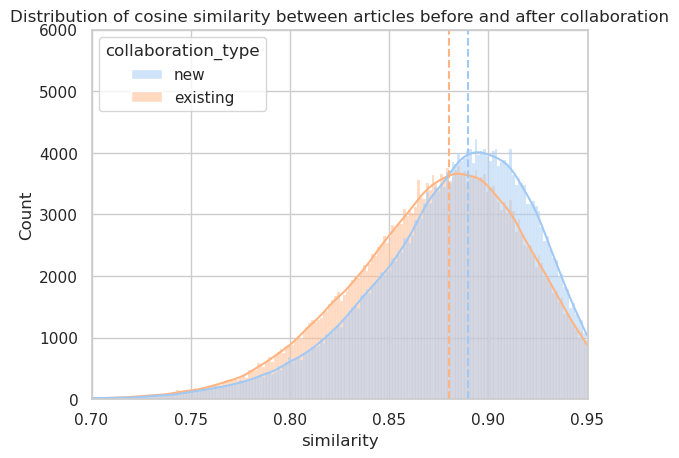

In [41]:
# Get palette
palette = sns.color_palette()

# Determine the unique collaboration types in the order they should appear
collaboration_order = df_similarities['collaboration_type'].unique()
# Draw histplot with KDEs
sns.histplot(data=df_similarities, 
             x='similarity',
             kde=True,
             hue='collaboration_type',
             hue_order=collaboration_order
            )

# Add medians with matching colors in the correct order
palette = sns.color_palette(n_colors=len(collaboration_order))
medians = df_similarities.groupby('collaboration_type')['similarity'].median()
for collaboration_type, color in zip(collaboration_order, palette):
    median = medians[collaboration_type]
    print(f'{collaboration_type} median: {median:.2f}')
    plt.axvline(median, linestyle='--', color=color, label=f'{collaboration_type} median')

plt.title("Distribution of cosine similarity between articles before and after collaboration")
plt.ylim(0, 6000)
plt.xlim(0.7, 0.95)
plt.show()

In [31]:
# Extract similarities for each collaboration type and convert to numpy arrays
similarities_new = np.array(df_similarities_new['similarity'], dtype=np.float32)
similarities_existing = np.array(df_similarities_existing['similarity'], dtype=np.float32)

# Calculate the Wasserstein distnace, i.e. earth mover distance
w_distance = wasserstein_distance(similarities_new, similarities_existing)
print(f"Wasserstein-1 distance (new vs existing): {w_distance:.4f}")

# Kolmogorov-Smirnov distribution equality test
ks_stat, p_value = ks_2samp(similarities_new, similarities_existing)
print(f"KS test stat: {round(ks_stat, 4)}, p-value: {round(p_value, 4)}")

Wasserstein-1 distance (new vs existing): 0.0083
KS test stat: 0.0898, p-value: 0.0


## Classifier test

Additionally, we will formulate this as a classification problem, where $Y$ will be the target variable distinguishing between new collaborations $y_{new}$ and existing collaborations $y_{existing}$. Given a publication $p$, we will again take only the closest publications before and after the publication of article $p$. Based on article embeddings, we will try to predict whether an article was published before or after the given publication date. This will help us understand if there a significant difference in publications before and after a given publication. The hypothesis of author's research direction impact of new collaborations will be accepted if the classifier will outperform the baseline classifier that classifies articles randomly. 

In [36]:
df_closest_articles_total = pd.DataFrame(results['closest_articles'])
df_closest_articles_total['timeline_label'] = df_closest_articles_total['timeline'].map({'before': 0, 'after': 1})

# Fetch the number of minimum samples in both timeline types
n_before = df_closest_articles_total[df_closest_articles_total['timeline'] == 'before']
n_after = df_closest_articles_total[df_closest_articles_total['timeline'] == 'after']
n_samples = min(len(n_before), len(n_after))

# Create a dataset of similarities balanced on timeline type
df_closest_articles_before = df_closest_articles_total[df_closest_articles_total['timeline'] == 'before'].sample(n=n_samples)
df_closest_articles_after = df_closest_articles_total[df_closest_articles_total['timeline'] == 'after'].sample(n=n_samples)
df_closest_articles = pd.concat([df_closest_articles_before, df_closest_articles_after])

df_closest_articles.head(5)

,article_id,similar_article_id,article_embedding,similar_article_embedding,collaboration_type,timeline,timeline_label
94494,84992386817,84983460903,"[0.02819584682583809, 0.03383694589138031, -0....","[0.054728008806705475, 0.026653148233890533, -...",new,before,0
115746,85108226937,85053709377,"[0.02498176507651806, 0.014295409433543682, 0....","[0.04579200968146324, 0.033657725900411606, 0....",new,before,0
10854,2-s2.0-85159254248,2-s2.0-85110957837,"[0.022552279755473137, 0.01583985798060894, -0...","[0.027070682495832443, 0.0102175772190094, -0....",existing,before,0
136246,84870610123,78651297088,"[0.019333094358444214, 0.014702977612614632, -...","[0.011120033450424671, 0.022417474538087845, -...",new,before,0
4396,2-s2.0-84893812582,2-s2.0-0035695496,"[0.007889934815466404, 0.027911072596907616, -...","[0.021708734333515167, 0.05246253311634064, 0....",existing,before,0


In [37]:
X = list()
y = list()
for i in tqdm(range(len(df_closest_articles))):
    sim_emb = df_closest_articles.loc[i, 'similar_article_embedding']
    art_emb = df_closest_articles.loc[i, 'article_embedding']
    # Convert to list (in case they're NumPy arrays), then concatenate
    combined_emb = list(sim_emb) + list(art_emb)
    X.append(combined_emb)
    y.append(df_closest_articles.loc[i, 'timeline_label'])

X = np.array(X) 

# Train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 259890/259890 [03:59<00:00, 1084.52it/s]


In [38]:
# Define the model, we use XGBoost classifier
model = xgboost.XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)
# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall:   {recall:.4f}")

Accuracy: 0.6725
Recall:   0.6272


Total importance for similar_article_embedding: 0.4667
Total importance for article_embedding: 0.5333


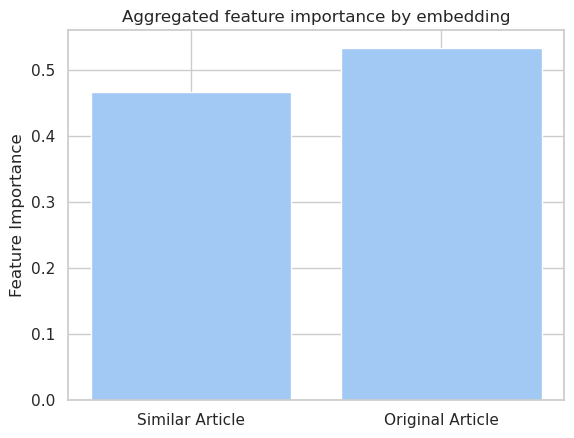

In [40]:
# Feature importance analysis to see if any of the embedddings (similar or original article) 
# is more important than the other in classifying the timeline.
feature_importances = model.feature_importances_

# Split into groups
n_features = len(feature_importances) // 2
similar_article_importance = feature_importances[:n_features]
article_importance = feature_importances[n_features:]

# Aggregate importance
similar_article_total = np.sum(similar_article_importance)
article_total = np.sum(article_importance)

print(f"Total importance for similar_article_embedding: {similar_article_total:.4f}")
print(f"Total importance for article_embedding: {article_total:.4f}")

# Visualization
labels = ['Similar Article', 'Original Article']
importance_values = [similar_article_total, article_total]

plt.bar(labels, importance_values)
plt.title("Aggregated feature importance by embedding")
plt.ylabel("Feature Importance")
plt.show()

## Top article impacts examples